In [1]:
import numpy as np
import pandas as pd 
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV 
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, BaggingRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.metrics import r2_score, mean_squared_error

import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import uniform


rs = 24

In [2]:
data = pd.read_csv('data.csv')
data.head()

,Country,Year,Status,Population,Hepatitis B,Measles,Polio,Diphtheria,HIV/AIDS,infant deaths,under-five deaths,Total expenditure,GDP,BMI,thinness 1-19 years,Alcohol,Schooling,Life expectancy
0,Afghanistan,2015,Developing,33736494.0,65.0,1154,6.0,65.0,0.1,62,83,8.16,584.259210,19.1,17.2,0.01,10.1,65.0
1,Afghanistan,2014,Developing,327582.0,62.0,492,58.0,62.0,0.1,64,86,8.18,612.696514,18.6,17.5,0.01,10.0,59.9
2,Afghanistan,2013,Developing,31731688.0,64.0,430,62.0,64.0,0.1,66,89,8.13,631.744976,18.1,17.7,0.01,9.9,59.9
3,Afghanistan,2012,Developing,3696958.0,67.0,2787,67.0,67.0,0.1,69,93,8.52,669.959000,17.6,17.9,0.01,9.8,59.5
4,Afghanistan,2011,Developing,2978599.0,68.0,3013,68.0,68.0,0.1,71,97,7.87,63.537231,17.2,18.2,0.01,9.5,59.2


<Axes: xlabel='Status'>

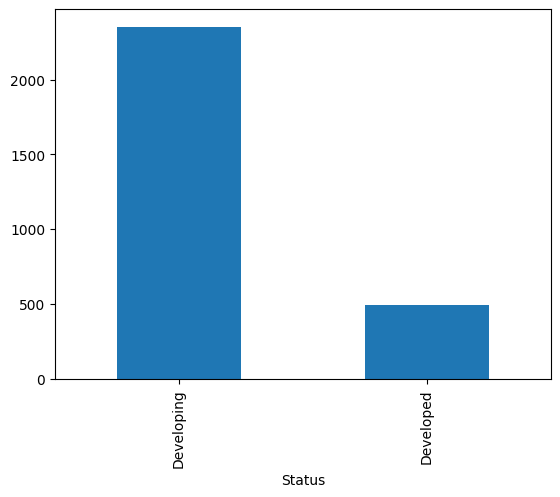

In [3]:
data['Status'].value_counts().plot(kind='bar')

In [4]:
class Preprocessing(): 
    def __init__(self):
        self.col_means = {} # based on each country
        self.col_medians = {}
    
    # Computing and remembering the mean (w.r.t. each country) and median value of each column
    def fit(self, data):
        cols_with_na = data.isna().sum()[data.isna().sum()>0].index.tolist()
        for col in cols_with_na:
            self.col_means[col] = data.groupby('Country')[col].transform('mean')
            self.col_medians[col] = data[col].median()

    # Applying preprocessing on data
    def transform(self, data):
        
        # Finding those columns which contain NaN values
        cols_with_na = data.isna().sum()[data.isna().sum()>0].index.tolist()
        # Fill NaN values of each column with its mean value (w.r.t. country)
        for col in cols_with_na:
            mean_value = self.col_means[col]
            data.loc[:, col] = data.loc[:, col].fillna(mean_value)

        # Finding those columns which still contain NaN values
        cols_with_na = data.isna().sum()[data.isna().sum()>0].index.tolist()
        # Fill NaN values of each column with median value
        for col in cols_with_na:
            median_value = self.col_medians[col]
            data.loc[:, col] = data.loc[:, col].fillna(median_value)
        
        # Encoding the Status column
        data['Status'] = data['Status'].map({'Developing' : 0, 'Developed' : 1,})
        
        return data

    # Applying preprocessing on training data
    def fit_transform(self, data):
        self.fit(data)
        return self.transform(data)

In [5]:
train, test = train_test_split(data, test_size=0.3, random_state=rs)

In [6]:
preprocesser = Preprocessing()

train = preprocesser.fit_transform(train)
test = preprocesser.transform(test)

In [7]:
test_data, val_data = train_test_split(test, test_size=0.5, random_state=rs)

In [8]:
train = train.drop('Country', axis=1)
val_data = val_data.drop('Country', axis=1)
test_data = test_data.drop('Country', axis=1)

<Axes: >

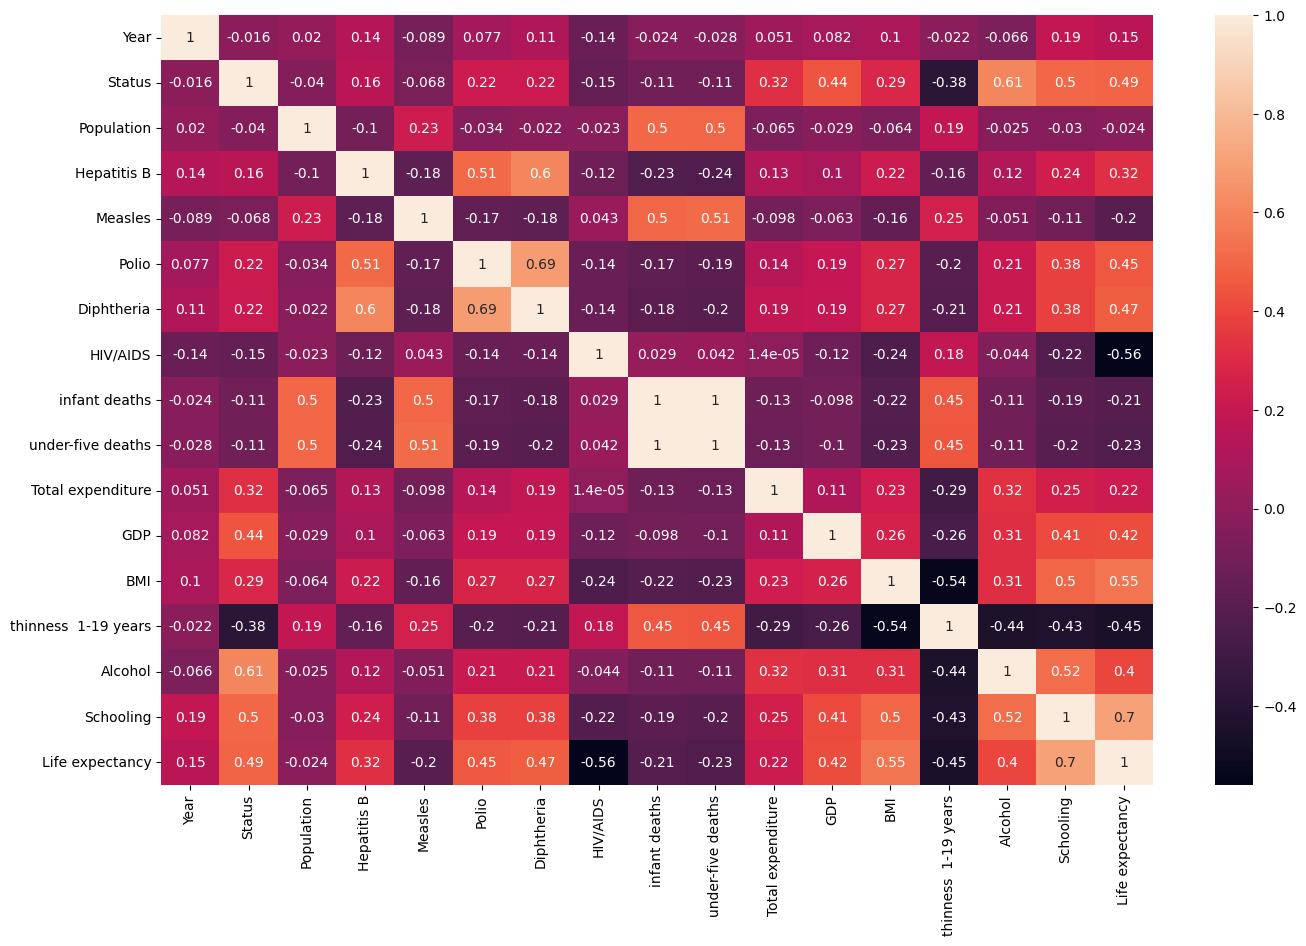

In [9]:
plt.figure(figsize=(16, 10))  
sns.heatmap(train.corr(), annot=True)

In [10]:
train.describe()

,Year,Status,Population,Hepatitis B,Measles,Polio,Diphtheria,HIV/AIDS,infant deaths,under-five deaths,Total expenditure,GDP,BMI,thinness 1-19 years,Alcohol,Schooling,Life expectancy
count,1993.000000,1993.000000,1.993000e+03,1993.000000,1993.000000,1993.000000,1993.000000,1993.000000,1993.000000,1993.000000,1993.000000,1993.000000,1993.000000,1993.000000,1993.000000,1993.000000,1993.000000
mean,2007.538384,0.180130,9.440680e+06,79.636282,1876.943803,82.347884,82.193929,1.686503,27.668841,38.457100,5.902017,6706.628408,38.807526,4.854039,4.651576,12.102107,69.463522
std,4.638720,0.384393,4.418552e+07,24.459128,9491.301015,23.672712,23.885691,5.093415,112.224946,153.118393,2.478318,13607.243501,19.746282,4.404019,4.077396,3.186977,9.356906
min,2000.000000,0.000000,3.400000e+01,1.000000,0.000000,3.000000,2.000000,0.100000,0.000000,0.000000,0.370000,3.685949,1.400000,0.100000,0.010000,0.000000,36.300000
25%,2004.000000,0.000000,4.162680e+05,74.000000,0.000000,78.000000,78.000000,0.100000,0.000000,0.000000,4.220000,612.623418,21.000000,1.600000,0.910000,10.400000,63.900000
50%,2008.000000,0.000000,1.354634e+06,91.000000,16.000000,93.000000,93.000000,0.100000,3.000000,4.000000,5.720000,1857.314509,44.200000,3.400000,3.810000,12.400000,72.200000
75%,2012.000000,0.000000,4.398942e+06,96.000000,354.000000,97.000000,97.000000,0.600000,21.000000,25.000000,7.430000,4735.484827,56.100000,7.100000,7.820000,14.100000,75.700000
max,2015.000000,1.000000,1.179681e+09,99.000000,212183.000000,99.000000,99.000000,50.600000,1800.000000,2400.000000,17.600000,119172.741800,77.100000,27.500000,17.870000,20.700000,89.000000


In [11]:
x_train, y_train = train.drop('Life expectancy', axis=1), train['Life expectancy']
x_val, y_val = val_data.drop('Life expectancy', axis=1), val_data['Life expectancy']
x_test, y_test = test_data.drop('Life expectancy', axis=1), test_data['Life expectancy']

In [12]:
std_scaler = StandardScaler()

x_train = std_scaler.fit_transform(x_train)
x_val = std_scaler.transform(x_val)
x_test = std_scaler.transform(x_test)

In [13]:
models = pd.DataFrame({"model":[], "r2_score":[], "mean_squared_error":[]})

<h1>Polynomial Regression</h1>

In [14]:
val_r2_scores = []
train_r2_scores = []

for k in range(1,3):
    poly_transformer = PolynomialFeatures(degree=k)
    poly_transformer.fit(x_train)
    poly_features = poly_transformer.transform(x_train)

    LR = LinearRegression()
    LR.fit(poly_features, y_train)

    valid_poly_features = poly_transformer.transform(x_val)
    y_pred = LR.predict(valid_poly_features)
    y_pred_t = LR.predict(poly_features)
    val_r2_scores.append(r2_score(y_val, y_pred))
    train_r2_scores.append(r2_score(y_train, y_pred_t))
    print(f'Validation r2_score for degree = {k} val:', r2_score(y_val, y_pred)) 
    print(f'Validation r2_score for degree = {k} train:', r2_score(y_train, y_pred_t)) 

Validation r2_score for degree = 1 val: 0.7691600506588944
Validation r2_score for degree = 1 train: 0.7739355318223353
Validation r2_score for degree = 2 val: 0.7462604698000832
Validation r2_score for degree = 2 train: 0.8917536650288898


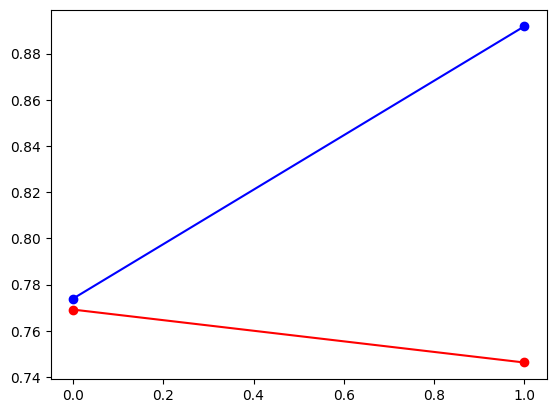

In [15]:
plt.plot(val_r2_scores, marker='o', linestyle='-', color='red', label='Data')
plt.plot(train_r2_scores, marker='o', linestyle='-', color='b', label='Data')

In [16]:
poly_transformer = PolynomialFeatures(degree=2)
poly_transformer.fit(x_train)
poly_features = poly_transformer.transform(x_train)

LR = LinearRegression()
LR.fit(poly_features, y_train)

LinearRegression()

In [17]:
test_poly_features = poly_transformer.transform(x_test)
y_pred = LR.predict(test_poly_features)

print("Mean Squared Error (MSE):", mean_squared_error(y_test, y_pred))
print('Validation r2_score for degree:', r2_score(y_test, y_pred)) 

Mean Squared Error (MSE): 15.005221805009137
Validation r2_score for degree: 0.8494751113937844


In [18]:
models.loc[len(models)] = ['Polynomial Regression', r2_score(y_test, y_pred), mean_squared_error(y_test, y_pred)]

<h1>ElasticNet </h1>


In [19]:
model = ElasticNet(random_state=rs)

param_distributions = {
    'alpha': uniform(0.1, 5.0),  
    'l1_ratio': uniform(0.1, 0.9)  
}

random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_distributions,
    n_iter=1000,  
    scoring='r2',
    cv=5,
    verbose=1,
    random_state=rs,
    n_jobs=-1
)

random_search.fit(x_train, y_train)
print("Best Parameters:", random_search.best_params_)

Fitting 5 folds for each of 1000 candidates, totalling 5000 fits
Best Parameters: {'alpha': np.float64(0.11293109525614844), 'l1_ratio': np.float64(0.6746571111591407)}


In [20]:
EN = random_search.best_estimator_

y_pred = EN.predict(x_val)
r2 = r2_score(y_val, y_pred)
print("R-squared (R2):", r2)

R-squared (R2): 0.7641713315791272


In [21]:
y_pred = EN.predict(x_test)

print("Mean Squared Error (MSE):", mean_squared_error(y_test, y_pred))
print('Validation r2_score for degree:', r2_score(y_test, y_pred)) 

Mean Squared Error (MSE): 22.815928934090767
Validation r2_score for degree: 0.771121999669151


In [22]:
models.loc[len(models)] = ['ElasticNet', r2_score(y_test, y_pred), mean_squared_error(y_test, y_pred)]

<h1>K-Nearest Neighbors (KNN)</h1>

The best value of k is: 8 with MSE = 13.612


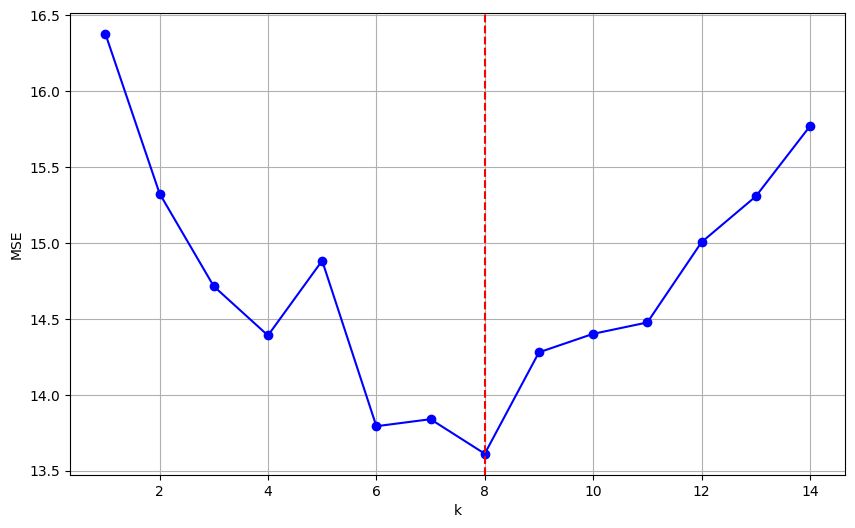

In [23]:
k_values = range(1, 15)   
mse_values = []

for k in k_values:
    knn = KNeighborsRegressor(n_neighbors=k)
    knn.fit(x_train, y_train)
    y_pred = knn.predict(x_val)
    mse = mean_squared_error(y_val, y_pred)
    mse_values.append(mse)

best_k = k_values[np.argmin(mse_values)]
print(f"The best value of k is: {best_k} with MSE = {min(mse_values):.3f}")

# Plot MSE vs. k
plt.figure(figsize=(10, 6))
plt.plot(k_values, mse_values, marker='o', color='blue', label='Mean Squared Error (MSE)')
plt.axvline(best_k, color='red', linestyle='--', label=f'Best k = {best_k}')
plt.xlabel('k')
plt.ylabel('MSE')
plt.grid()
plt.show()

In [24]:
knn = KNeighborsRegressor(n_neighbors=best_k)
knn.fit(x_train, y_train)

KNeighborsRegressor(n_neighbors=8)

In [25]:
y_pred = knn.predict(x_test)

print("Mean Squared Error (MSE):", mean_squared_error(y_test, y_pred))
print('Validation r2_score for degree:', r2_score(y_test, y_pred)) 

Mean Squared Error (MSE): 12.734485509367678
Validation r2_score for degree: 0.8722540034619721


In [26]:
models.loc[len(models)] = ['KNN', r2_score(y_test, y_pred), mean_squared_error(y_test, y_pred)]

<h1>Decision Tree</h1>

In [27]:
model = DecisionTreeRegressor(random_state=rs)
param_grid = {
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(x_train, y_train)

print("Best Hyperparameters:", grid_search.best_params_)

Best Hyperparameters: {'max_depth': 15, 'min_samples_leaf': 4, 'min_samples_split': 2}


In [28]:
DT = grid_search.best_estimator_

y_pred = DT.predict(x_val)
mse = mean_squared_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")

Mean Squared Error: 10.16624261140565
R^2 Score: 0.8946520974450276


In [29]:
y_pred = DT.predict(x_test)

print("Mean Squared Error (MSE):", mean_squared_error(y_test, y_pred))
print('Validation r2_score for degree:', r2_score(y_test, y_pred)) 

Mean Squared Error (MSE): 7.340579063481034
Validation r2_score for degree: 0.9263629781555949


In [30]:
models.loc[len(models)] = ['Decision Tree', r2_score(y_test, y_pred), mean_squared_error(y_test, y_pred)]

<h1>Random Forest</h1>

In [31]:
param_distributions = {
    'n_estimators': [50, 100, 150, 200],
    'max_depth': [None, 10, 20, 30, 40],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

random_search = RandomizedSearchCV(
    estimator=RandomForestRegressor(random_state=rs),
    param_distributions=param_distributions,
    n_iter=50,
    cv=5,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

random_search.fit(x_train, y_train)

print("Best Hyperparameters:", random_search.best_params_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best Hyperparameters: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': None}


In [32]:
RF = random_search.best_estimator_
y_pred = RF.predict(x_val)

mse = mean_squared_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")

Mean Squared Error: 5.708257133177578
R^2 Score: 0.9408480655822584


In [33]:
y_pred = RF.predict(x_test)

print("Mean Squared Error (MSE):", mean_squared_error(y_test, y_pred))
print('Validation r2_score for degree:', r2_score(y_test, y_pred)) 

Mean Squared Error (MSE): 5.813665196135827
Validation r2_score for degree: 0.9416802152334698


In [34]:
models.loc[len(models)] = ['Random Forest', r2_score(y_test, y_pred), mean_squared_error(y_test, y_pred)]

<h1>Gradient Boosting<h1>

In [35]:
model = GradientBoostingRegressor(random_state=rs)

param_distributions = {
    'n_estimators': [100, 200, 300, 400, 500],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 4, 5, 6],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'subsample': [0.6, 0.8, 1.0]
}

random_search = RandomizedSearchCV(estimator=model, param_distributions=param_distributions,
                                   n_iter=50, scoring='neg_mean_squared_error', cv=5,
                                   verbose=2, random_state=rs, n_jobs=-1)

random_search.fit(x_train, y_train)
print("Best Hyperparameters:", random_search.best_params_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best Hyperparameters: {'subsample': 0.6, 'n_estimators': 400, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_depth': 6, 'learning_rate': 0.05}


In [36]:
GB = random_search.best_estimator_

y_pred = GB.predict(x_val)

mse = mean_squared_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")

Mean Squared Error: 5.156935431431367
R^2 Score: 0.9465611482945321


In [37]:
y_pred = GB.predict(x_test)

print("Mean Squared Error (MSE):", mean_squared_error(y_test, y_pred))
print('Validation r2_score for degree:', r2_score(y_test, y_pred)) 

Mean Squared Error (MSE): 4.862769555616218
Validation r2_score for degree: 0.9512191252359576


In [38]:
models.loc[len(models)] = ['Gradient Boosting', r2_score(y_test, y_pred), mean_squared_error(y_test, y_pred)]

<h1>SVM<h1>

In [39]:
svr = SVR()

param_grid = {
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'C': [0.1, 0.5, 1, 5, 10, 20, 100, 500],
    'gamma': ['scale', 'auto']
}

grid_search = GridSearchCV(svr, param_grid, cv=2, scoring='neg_mean_squared_error', verbose=2, n_jobs=-1)
grid_search.fit(x_train, y_train)
print("Best Hyperparameters:", grid_search.best_params_)

Fitting 2 folds for each of 64 candidates, totalling 128 fits
Best Hyperparameters: {'C': 100, 'gamma': 'scale', 'kernel': 'rbf'}


In [40]:
SVM = grid_search.best_estimator_

y_pred = SVM.predict(x_val)

mse = mean_squared_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")

Mean Squared Error: 11.088166824993351
R^2 Score: 0.8850986384210277


In [41]:
y_pred = SVM.predict(x_test)

print("Mean Squared Error (MSE):", mean_squared_error(y_test, y_pred))
print('Validation r2_score for degree:', r2_score(y_test, y_pred)) 

Mean Squared Error (MSE): 10.374909435763115
Validation r2_score for degree: 0.8959240917987306


In [42]:
models.loc[len(models)] = ['svm', r2_score(y_test, y_pred), mean_squared_error(y_test, y_pred)]

<h1>Bagging<h1>

In [43]:
base_model = DecisionTreeRegressor(random_state=42)

bagging_model = BaggingRegressor(base_model, random_state=rs)

param_grid = {
    'n_estimators': [10, 50, 100, 200],  
    'max_samples': [0.5, 0.7, 1.0],       
    'max_features': [0.5, 0.7, 1.0],      
    'bootstrap': [True, False]           
}

grid_search = RandomizedSearchCV(estimator=bagging_model, param_distributions=param_grid, cv=5, n_jobs=-1, scoring='neg_mean_squared_error')

grid_search.fit(x_train, y_train)
print("Best Hyperparameters:", grid_search.best_params_)

Best Hyperparameters: {'n_estimators': 100, 'max_samples': 1.0, 'max_features': 1.0, 'bootstrap': True}


In [44]:
bagging = grid_search.best_estimator_

y_pred = bagging.predict(x_val)

mse = mean_squared_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")

Mean Squared Error: 5.511463885514029
R^2 Score: 0.9428873397438918


In [45]:
y_pred = bagging.predict(x_test)

print("Mean Squared Error (MSE):", mean_squared_error(y_test, y_pred))
print('Validation r2_score for degree:', r2_score(y_test, y_pred)) 

Mean Squared Error (MSE): 5.629229934426226
Validation r2_score for degree: 0.9435303776359095


In [46]:
models.loc[len(models)] = ['Bagging', r2_score(y_test, y_pred), mean_squared_error(y_test, y_pred)]

<h1>Best Model

In [47]:
models.sort_values(by='r2_score', ascending=False)

,model,r2_score,mean_squared_error
5,Gradient Boosting,0.951219,4.862770
7,Bagging,0.943530,5.629230
4,Random Forest,0.941680,5.813665
3,Decision Tree,0.926363,7.340579
6,svm,0.895924,10.374909
2,KNN,0.872254,12.734486
0,Polynomial Regression,0.849475,15.005222
1,ElasticNet,0.771122,22.815929
